## Connect to Google Colab

To train the network on a GPU, Google Colab will be used. To connect to Google Colab successfully, adjust `gdrive_path` so that it represents the root folder of the repository. In case you don't want to use Google Colab you can skip this cell.

In [1]:
from google.colab import drive
import os

# set path to project folder
gdrive_path='/content/gdrive/MyDrive/7-programming/music_recognition/'

# mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# navigate to Google Drive folder
os.chdir(gdrive_path)

# check that we are in the right folder
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.git', '.gitignore', 'README.md', 'data', 'data_loader.ipynb']


## Manage Imports

Throughout the repository, we will use a wide range of external packages. If you use Google Colab, these packages need to be installed using `pip` every time you restart the kernel. If you don't use Google Colab, you can create a virtual environment to manage packages and versions. In this case, you only need to install these packages with `pip` once.

In [2]:
import torch
from data.primus_dataset import PrimusDataset, split_data, visualize_sample

# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Data

Next, we will load the Primus dataset that will be used throughout this notebook. The dataset was published as part of the following publication:

```
@inproceedings{calvo2018camera,
  title={Camera-PrIMuS: Neural End-to-End Optical Music Recognition on Realistic Monophonic Scores.},
  author={Calvo-Zaragoza, Jorge and Rizo, David},
  booktitle={ISMIR},
  pages={248--255},
  year={2018}
}
```

It contains 87,678 labeled images of monophonic scores and can be downloaded from https://grfia.dlsi.ua.es/primus/. Make sure to specify the `data_root`-path to the dataset correctly. In our case, we stored it in `/<repository_root>/data/primus/`. Each sample in that dataset consists of a directory that is named e.g. `000051650-1_1_1` and contains 6 files.
*   `000051650-1_1_1_distorted.jpg`: The sample image with applied transformations
*   `000051650-1_1_1.agnostic`: Graphical elements with their position in the score
*   `000051650-1_1_1.mei`: Semantically labeled image in `.mei`-format, i.e. XML representation
*   `000051650-1_1_1.png`: The original image without any transformations
*   `000051650-1_1_1.semantic`: Semantically labeled image
*   `regular_pae.pae`: Image in format of data source taken from RISM-dataset

Note that we will make predictions based on the undistorted `.png`-image and the `.semantic`-labeling of music notation.



In [4]:
# load dataset
data_path = os.path.join(gdrive_path, 'data', 'primus')
vocabulary_path = os.path.join(gdrive_path, 'data', 'semantic_labels.txt')
dataset = PrimusDataset(data_path=data_path, vocabulary_path=vocabulary_path)

# apply train-val-test split
train_data, val_data, test_data = split_data(dataset)

+------------+-----------+
| Dataset    | # Samples |
+------------+-----------+
| Train      |     6     |
| Validation |     2     |
| Test       |     2     |
+------------+-----------+


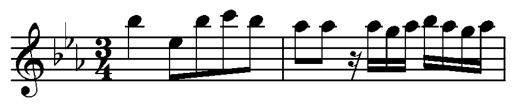

Labels: clef-G2	keySignature-EbM	timeSignature-3/4	note-Bb5_quarter	note-Eb5_eighth	note-Bb5_eighth	note-C6_eighth	note-Bb5_eighth	barline	note-Ab5_eighth	note-Ab5_eighth	rest-sixteenth	note-Ab5_sixteenth	note-G5_sixteenth	note-Ab5_sixteenth	note-Bb5_sixteenth	note-Ab5_sixteenth	note-G5_sixteenth	note-Ab5_sixteenth	barline	


In [5]:
visualize_sample(train_data)

In [7]:
print(dataset.index_to_vocabulary)

{0: 'barline', 1: 'clef-C1', 2: 'clef-C2', 3: 'clef-C3', 4: 'clef-C4', 5: 'clef-C5', 6: 'clef-F3', 7: 'clef-F4', 8: 'clef-F5', 9: 'clef-G1', 10: 'clef-G2', 11: 'gracenote-A2_eighth', 12: 'gracenote-A2_quarter', 13: 'gracenote-A2_sixteenth', 14: 'gracenote-A#3_eighth', 15: 'gracenote-A3_eighth', 16: 'gracenote-A3_half', 17: 'gracenote-A3_quarter', 18: 'gracenote-A#3_sixteenth', 19: 'gracenote-A3_sixteenth', 20: 'gracenote-A3_thirty_second', 21: 'gracenote-A#4_eighth', 22: 'gracenote-A4_eighth', 23: 'gracenote-A#4_half', 24: 'gracenote-A4_half', 25: 'gracenote-A#4_quarter', 26: 'gracenote-A4_quarter', 27: 'gracenote-A#4_sixteenth', 28: 'gracenote-A4_sixteenth', 29: 'gracenote-A#4_thirty_second', 30: 'gracenote-A4_thirty_second', 31: 'gracenote-A#5_eighth', 32: 'gracenote-A5_eighth', 33: 'gracenote-A5_quarter', 34: 'gracenote-A5_sixteenth', 35: 'gracenote-A5_sixteenth.', 36: 'gracenote-A5_thirty_second', 37: 'gracenote-Ab3_double_whole', 38: 'gracenote-Ab3_eighth', 39: 'gracenote-Ab3_sixt